###
Initializing Spark session.

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName("PredictiveAnalysis").getOrCreate()

####
Import Libraries

In [ ]:
from pyspark.sql.functions import col, sum, lower, count, expr,year, month
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

##
Data Cleaning

####
Loading the dataset into a Spark DataFrame.

In [ ]:
coffee_data_df = spark.read.csv("/FileStore/tables/Coffee_Shop_Sales-1.csv", header= True, inferSchema=True)
coffee_data_df.show(3)

+--------------+----------------+-------------------+---------------+--------+---------------+----------+----------+------------------+--------------------+--------------------+
|transaction_id|transaction_date|   transaction_time|transaction_qty|store_id| store_location|product_id|unit_price|  product_category|        product_type|      product_detail|
+--------------+----------------+-------------------+---------------+--------+---------------+----------+----------+------------------+--------------------+--------------------+
|             1|      2023-01-01|2024-08-24 07:06:11|              2|       5|Lower Manhattan|        32|       2.4|            Coffee|Gourmet brewed co...|         Ethiopia Rg|
|             2|      2023-01-01|2024-08-24 07:08:56|              2|       5|Lower Manhattan|        57|       3.1|               Tea|     Brewed Chai tea|Spicy Eye Opener ...|
|             3|      2023-01-01|2024-08-24 07:14:04|              2|       5|Lower Manhattan|        59|     

##
Inspecting Data for Inconsistencies, Missing Values, or Duplicates

####
Inspect the schema of the DataFrame

In [ ]:
coffee_data_df.printSchema()

root
 |-- transaction_id: integer (nullable = true)
 |-- transaction_date: date (nullable = true)
 |-- transaction_time: timestamp (nullable = true)
 |-- transaction_qty: integer (nullable = true)
 |-- store_id: integer (nullable = true)
 |-- store_location: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- product_category: string (nullable = true)
 |-- product_type: string (nullable = true)
 |-- product_detail: string (nullable = true)



####Showing summary statistics

In [ ]:
coffee_data_df.describe().show()

+-------+-----------------+------------------+-----------------+---------------+------------------+------------------+----------------+----------------+--------------------+
|summary|   transaction_id|   transaction_qty|         store_id| store_location|        product_id|        unit_price|product_category|    product_type|      product_detail|
+-------+-----------------+------------------+-----------------+---------------+------------------+------------------+----------------+----------------+--------------------+
|  count|           149116|            149116|           149116|         149116|            149116|            149116|          149116|          149116|              149116|
|   mean|74737.37187156308| 1.438276241315486|5.342062555326055|           null| 47.91860699053086|3.2370985004966166|            null|            null|                null|
| stddev|43153.60001591776|0.5425087647372203|  2.0742405915717|           null|17.930020247641522|2.6648702418711308|            

####Checking for missing values

In [ ]:
missing_values = coffee_data_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in coffee_data_df.columns])
missing_values.show()

+--------------+----------------+----------------+---------------+--------+--------------+----------+----------+----------------+------------+--------------+
|transaction_id|transaction_date|transaction_time|transaction_qty|store_id|store_location|product_id|unit_price|product_category|product_type|product_detail|
+--------------+----------------+----------------+---------------+--------+--------------+----------+----------+----------------+------------+--------------+
|             0|               0|               0|              0|       0|             0|         0|         0|               0|           0|             0|
+--------------+----------------+----------------+---------------+--------+--------------+----------+----------+----------------+------------+--------------+



####Checking for duplicates

In [ ]:
duplicates = coffee_data_df.groupBy(coffee_data_df.columns).count().filter("count > 1")
total_duplicate_rows = duplicates.withColumn("duplicate_count", col("count") - 1).agg(sum("duplicate_count")).collect()[0][0]
print(f"Number of duplicate rows: {total_duplicate_rows}")

Number of duplicate rows: None


##Data Cleaning Process

####Correct Inconsistencies

In [ ]:
coffee_data_df = coffee_data_df.withColumn("store_location", lower(col("store_location"))) \
                   .withColumn("product_category", lower(col("product_category"))) \
                   .withColumn("product_type", lower(col("product_type"))) \
                   .withColumn("product_detail", lower(col("product_detail")))
coffee_data_df.show(3)

+--------------+----------------+-------------------+---------------+--------+---------------+----------+----------+------------------+--------------------+--------------------+
|transaction_id|transaction_date|   transaction_time|transaction_qty|store_id| store_location|product_id|unit_price|  product_category|        product_type|      product_detail|
+--------------+----------------+-------------------+---------------+--------+---------------+----------+----------+------------------+--------------------+--------------------+
|             1|      2023-01-01|2024-08-24 07:06:11|              2|       5|lower manhattan|        32|       2.4|            coffee|gourmet brewed co...|         ethiopia rg|
|             2|      2023-01-01|2024-08-24 07:08:56|              2|       5|lower manhattan|        57|       3.1|               tea|     brewed chai tea|spicy eye opener ...|
|             3|      2023-01-01|2024-08-24 07:14:04|              2|       5|lower manhattan|        59|     

## Profit/Loss Analysis

####Calculate Total Sales and Revenue for Each Product

####Calculate total revenue and total cost (Assuming Cost Price)

In [ ]:
cost_price_percentage = 0.7 # 70% of the unit price
coffee_data_df = coffee_data_df.withColumn("total_revenue", col("transaction_qty") * col("unit_price")) \
                               .withColumn("total_cost", col("transaction_qty") * col("unit_price") * cost_price_percentage)

####Aggregate data

In [ ]:
product_sales = coffee_data_df.groupBy("product_id", "product_category", "product_type", "product_detail") \
                              .agg(sum("transaction_qty").alias("total_sales_qty"),
                                   sum("total_revenue").alias("total_revenue"),
                                   sum("total_cost").alias("total_cost"))

####Determine Profit or Loss 

In [ ]:
product_sales = product_sales.withColumn("profit_loss", col("total_revenue") - col("total_cost"))
product_sales.show()

+----------+------------------+--------------------+--------------------+---------------+------------------+------------------+------------------+
|product_id|  product_category|        product_type|      product_detail|total_sales_qty|     total_revenue|        total_cost|       profit_loss|
+----------+------------------+--------------------+--------------------+---------------+------------------+------------------+------------------+
|        24|            coffee|         drip coffee|our old time dine...|           3997|           11991.0| 8393.699999999926| 3597.300000000074|
|        48|               tea|    brewed black tea|english breakfast rg|           4200|           10500.0|            7350.0|            3150.0|
|        52|               tea|     brewed chai tea|traditional blend...|           4512|           11280.0|            7896.0|            3384.0|
|        11|         loose tea|          herbal tea|         lemon grass|            152|1354.7499999999993| 948.32499

####Join coffee_data_df with product_sales to add profit_loss column

In [ ]:
coffee_data_df = coffee_data_df.join(
    product_sales.select("product_id", "product_category", "product_type", "product_detail", "profit_loss"),
    on=["product_id", "product_category", "product_type", "product_detail"],
    how="left"
)

####Visualize the Data (For total revenue)

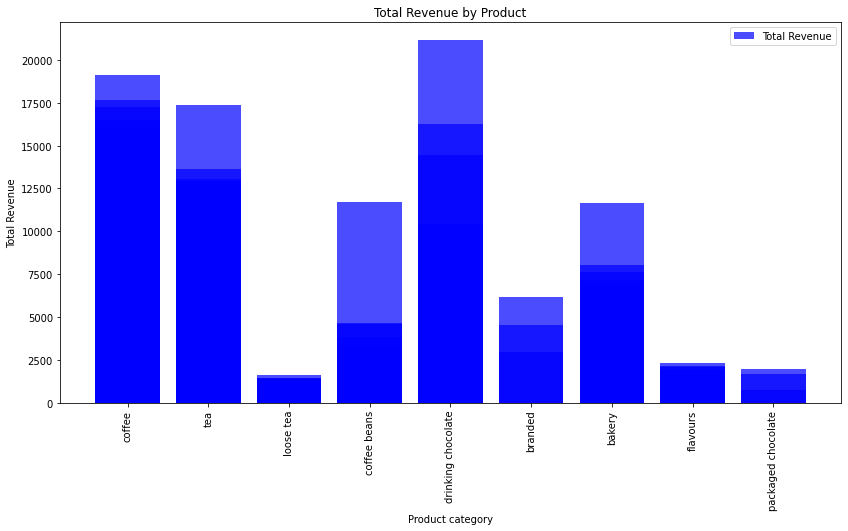

In [ ]:
product_sales_pd = product_sales.toPandas()

# Bar plot for total revenue
plt.figure(figsize=(14, 7))
plt.bar(product_sales_pd["product_category"], product_sales_pd["total_revenue"], color='blue', alpha=0.7, label='Total Revenue')
plt.xticks(rotation=90)
plt.xlabel('Product category')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Product')
plt.legend()
plt.show()

%md
####Visualize the Data (For profit/loss)

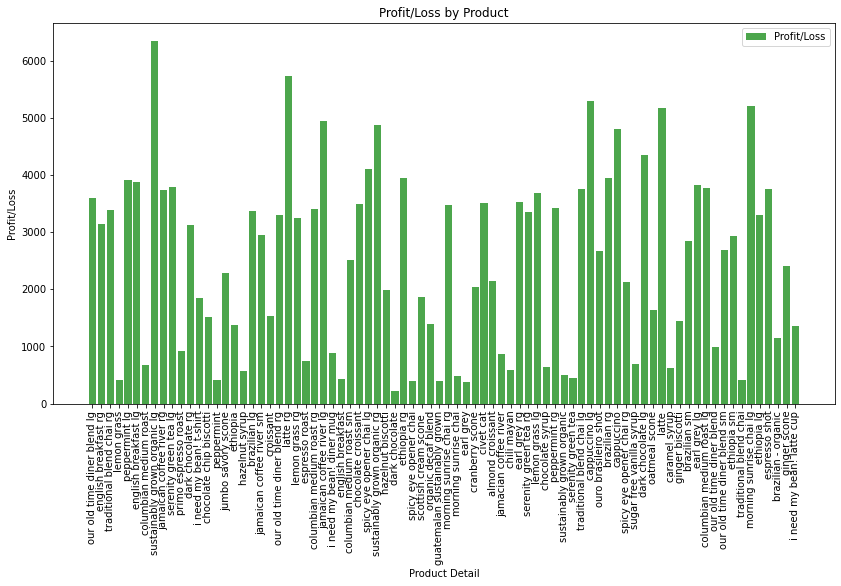

In [ ]:
# Bar plot for profit/loss
plt.figure(figsize=(14, 7))
plt.bar(product_sales_pd["product_detail"], product_sales_pd["profit_loss"], color='green', alpha=0.7, label='Profit/Loss')
plt.xticks(rotation=90)
plt.xlabel('Product Detail')
plt.ylabel('Profit/Loss')
plt.title('Profit/Loss by Product')
plt.legend()
plt.show()

### Trend Analysis Over Time

###### Extract year and month from the transaction_date

In [ ]:
coffee_data_df = coffee_data_df.withColumn("year", year(col("transaction_date"))) \
                   .withColumn("month", month(col("transaction_date")))

##### Group by year and month to calculate monthly sales and revenue

In [ ]:
monthly_sales = coffee_data_df.groupBy("year", "month") \
                        .agg(sum("transaction_qty").alias("total_sales_qty"),
                             sum(expr("transaction_qty * unit_price")).alias("total_revenue"))
monthly_sales = monthly_sales.orderBy("year", "month")
monthly_sales.show(5)

+----+-----+---------------+------------------+
|year|month|total_sales_qty|     total_revenue|
+----+-----+---------------+------------------+
|2023|    1|          24870| 78258.38999999811|
|2023|    2|          23550| 72876.18999999786|
|2023|    3|          30406| 94750.22999999751|
|2023|    4|          36469|113928.43000000228|
|2023|    5|          48233|150185.70999999833|
+----+-----+---------------+------------------+
only showing top 5 rows



####Line plot for monthly sales quantity and monthly revenue

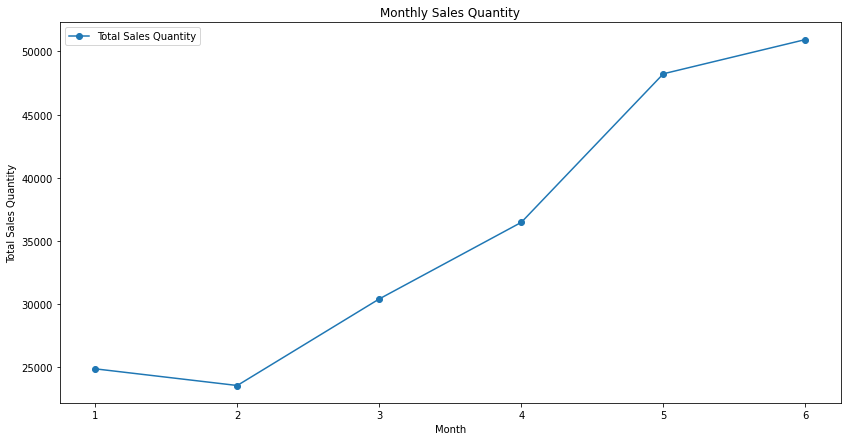

In [ ]:
monthly_sales_pd = monthly_sales.toPandas()

# Line plot for monthly sales quantity
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales_pd["month"], monthly_sales_pd["total_sales_qty"], marker='o', label='Total Sales Quantity')
plt.xlabel('Month')
plt.ylabel('Total Sales Quantity')
plt.title('Monthly Sales Quantity')
plt.legend()
plt.show()

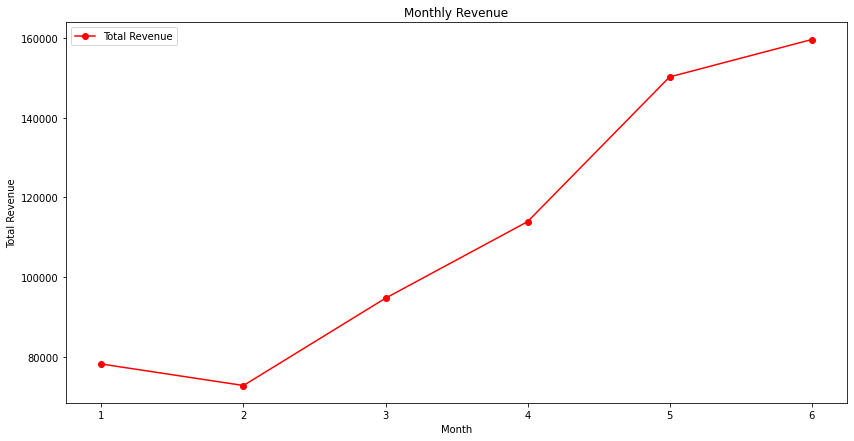

In [ ]:
# Line plot for monthly revenue
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales_pd["month"], monthly_sales_pd["total_revenue"], marker='o', color='red', label='Total Revenue')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.title('Monthly Revenue')
plt.legend()
plt.show()

###Store Performance Analysis

In [ ]:
store_performance = coffee_data_df.groupBy("store_location") \
                            .agg(sum("transaction_qty").alias("total_sales_qty"),
                                 sum(expr("transaction_qty * unit_price")).alias("total_revenue"))

store_performance.show()


+---------------+---------------+------------------+
| store_location|total_sales_qty|     total_revenue|
+---------------+---------------+------------------+
| hell's kitchen|          71737| 226634.9699999933|
|        astoria|          70991|222116.85999999268|
|lower manhattan|          71742|220794.54999999327|
+---------------+---------------+------------------+



####Bar plot for store performance

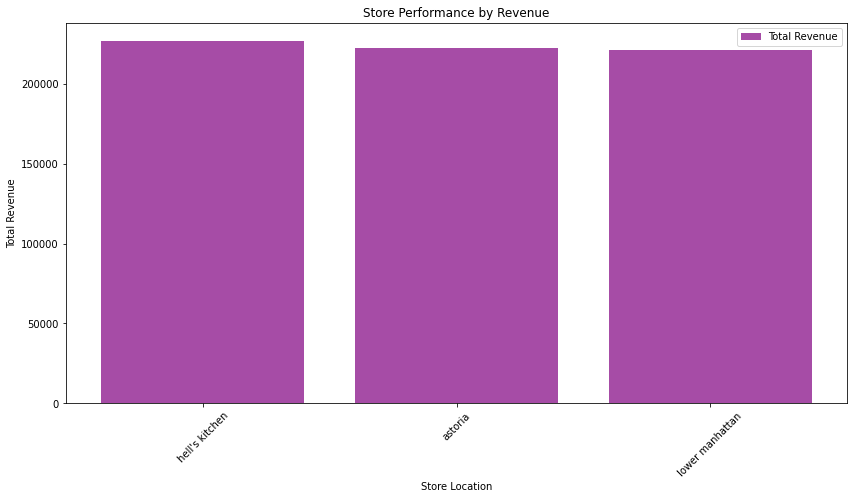

In [ ]:
store_performance_pd = store_performance.toPandas()
# Bar plot for store performance
plt.figure(figsize=(14, 7))
plt.bar(store_performance_pd["store_location"], store_performance_pd["total_revenue"], color='purple', alpha=0.7, label='Total Revenue')
plt.xticks(rotation=45)
plt.xlabel('Store Location')
plt.ylabel('Total Revenue')
plt.title('Store Performance by Revenue')
plt.legend()
plt.show()

###Sales and Profit Margins

#####Highest profit Margin Product Category

In [ ]:
coffee_data_df = coffee_data_df.withColumn("profit_margin", col("profit_loss") / col("total_revenue"))

highest_margin_products = coffee_data_df.orderBy(col("profit_margin").desc()).limit(10)
highest_margin_products.select("product_category","profit_margin").show(1)


+------------------+-----------------+
|  product_category|    profit_margin|
+------------------+-----------------+
|drinking chocolate|3730.332352941229|
+------------------+-----------------+
only showing top 1 row



#####Lowest Margin Product Category

In [ ]:
lowest_margin_products = coffee_data_df.orderBy(col("profit_margin")).limit(10)
lowest_margin_products.select("product_category","profit_margin").show(1)

+----------------+-----------------+
|product_category|    profit_margin|
+----------------+-----------------+
|    coffee beans|9.750000000000005|
+----------------+-----------------+
only showing top 1 row



##Profit Increase Prediction

##### StringIndexer for categorical features and  Assembling those features into a single vector

In [ ]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(coffee_data_df) for column in ["product_category", "product_type"]]
for indexer in indexers:
    coffee_data_df = indexer.transform(coffee_data_df)

# Assembling the features into a single vector
assembler = VectorAssembler(inputCols=["transaction_qty", "unit_price", "product_category_index", "product_type_index"],
                            outputCol="features")
df_model = assembler.transform(coffee_data_df)
df_model = df_model.select("features", "profit_loss")

df_model.show(5)

+-----------------+------------------+
|         features|       profit_loss|
+-----------------+------------------+
|[2.0,2.4,0.0,1.0]|3953.3400000001056|
|[2.0,3.1,1.0,0.0]|4095.7199999997392|
|[2.0,2.4,3.0,3.0]| 4340.819999999763|
|[1.0,2.0,0.0,8.0]|2690.3999999999924|
|[2.0,3.1,1.0,0.0]|4095.7199999997392|
+-----------------+------------------+
only showing top 5 rows



###Model Selection and Training

####I am use the Random Forest Regressor for this task.

In [ ]:
RanFor = RandomForestRegressor(labelCol="profit_loss", featuresCol="features", numTrees=100)

train_data, test_data = df_model.randomSplit([0.8, 0.2], seed=42)

rf_model = RanFor.fit(train_data)

##Model Prediction and Evaluation

In [ ]:
predictions = rf_model.transform(test_data)

In [ ]:
evaluator = RegressionEvaluator(labelCol="profit_loss", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Root Mean Squared Error (RMSE): 244.63613848581156
R-squared (R2): 0.9616383252764448


##Profit Prediction

In [ ]:
profit_predictions = rf_model.transform(df_model)
profit_predictions.select("profit_loss", "prediction").show(10)


+------------------+------------------+
|       profit_loss|        prediction|
+------------------+------------------+
|3953.3400000001056| 2937.794891607997|
|4095.7199999997392|3762.3105819609495|
| 4340.819999999763| 3496.023252982598|
|2690.3999999999924|2879.9584769693092|
|4095.7199999997392|3762.3105819609495|
|1637.9999999999968| 1782.700583408882|
|2690.3999999999924|2879.9584769693092|
|2506.7999999999984|2908.4605063424406|
| 5733.675000000174| 5352.193175944729|
|3125.3399999998546| 3496.023252982598|
+------------------+------------------+
only showing top 10 rows



##Recommendations

In [ ]:
top_profit_predictions = profit_predictions.orderBy(col("prediction").desc()).show(1)

+------------------+----------------+-----------------+
|          features|     profit_loss|       prediction|
+------------------+----------------+-----------------+
|[2.0,4.75,3.0,3.0]|6341.56500000009|6069.344741887474|
+------------------+----------------+-----------------+
only showing top 1 row



## Feature Importance Analysis

#### Extract feature importances

In [ ]:
importances = rf_model.featureImportances

#### Creating Pandas DataFrame for better visualization

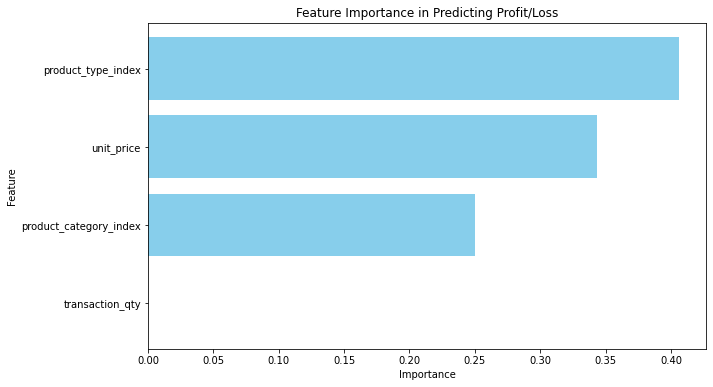

In [ ]:
feature_importance_df = pd.DataFrame({
    "feature": ["transaction_qty", "unit_price", "product_category_index", "product_type_index"],
    "importance": importances.toArray()
})

feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Predicting Profit/Loss")
plt.gca().invert_yaxis()
plt.show()

##Scenario Analysis

#### Define a list of scenarios with hard-coded changes and creating Dataframe from it.

In [ ]:
scenarios = [
    {"transaction_qty": 10, "unit_price": 5.0, "product_category_index": 0, "product_type_index": 1},
    {"transaction_qty": 15, "unit_price": 4.5, "product_category_index": 1, "product_type_index": 2},
    {"transaction_qty": 20, "unit_price": 6.0, "product_category_index": 3, "product_type_index": 3},
]

scenarios_df = pd.DataFrame(scenarios)
scenarios_spark_df = spark.createDataFrame(scenarios_df)

###Assemble the features for the scenarios and Predict profit/loss for each scenario.

In [ ]:
    scenario_features = assembler.transform(scenarios_spark_df)

    # Predict profit/loss for each scenario
    scenario_predictions = rf_model.transform(scenario_features)

    scenario_predictions.select("features", "prediction").show()

+------------------+-----------------+
|          features|       prediction|
+------------------+-----------------+
|[10.0,5.0,0.0,1.0]|5105.963758754502|
|[15.0,4.5,1.0,2.0]|5704.559157106808|
|[20.0,6.0,3.0,3.0]|5943.712423175242|
+------------------+-----------------+



##Loss Mitigation Strategies

#### Identify Loss-Making Products

######Upon analyzing the product data, it was observed that no products or services were experiencing losses. All products show a positive profit margin.Therefore, the loss mitigation strategies section is not applicable for this dataset.

In [ ]:
loss_making_products = product_sales.filter(col("profit_loss") <0)

loss_making_products.show(truncate=False)


+----------+----------------+------------+--------------+---------------+-------------+----------+-----------+
|product_id|product_category|product_type|product_detail|total_sales_qty|total_revenue|total_cost|profit_loss|
+----------+----------------+------------+--------------+---------------+-------------+----------+-----------+
+----------+----------------+------------+--------------+---------------+-------------+----------+-----------+



In [ ]:
total_loss_count = loss_making_products.count()
print(f"Total number of products in loss: {total_loss_count}")


Total number of products in loss: 0


###Savinga DataFrame as a Cleaned Dataset in CSV file format

In [ ]:
output_path = "dbfs:/Desktop/Coffee_Clean_Data"
coffee_data_df.coalesce(1).write.mode("overwrite").option("header", "true").csv(output_path)


In [ ]:
files = dbutils.fs.ls("dbfs:/Desktop/Coffee_Clean_Data")
display(files)


path,name,size,modificationTime
dbfs:/Desktop/Coffee_Clean_Data/_SUCCESS,_SUCCESS,0,1724498144000
dbfs:/Desktop/Coffee_Clean_Data/_committed_1755086449704234385,_committed_1755086449704234385,113,1724497990000
dbfs:/Desktop/Coffee_Clean_Data/_committed_8956154481424602482,_committed_8956154481424602482,212,1724498031000
dbfs:/Desktop/Coffee_Clean_Data/_committed_946712081873331209,_committed_946712081873331209,200,1724498144000
dbfs:/Desktop/Coffee_Clean_Data/_started_1755086449704234385,_started_1755086449704234385,0,1724497982000
dbfs:/Desktop/Coffee_Clean_Data/_started_8956154481424602482,_started_8956154481424602482,0,1724498023000
dbfs:/Desktop/Coffee_Clean_Data/_started_946712081873331209,_started_946712081873331209,0,1724498138000
dbfs:/Desktop/Coffee_Clean_Data/part-00000-tid-946712081873331209-b0618037-150e-4f7f-a390-e3e211403c47-413-1-c000.csv,part-00000-tid-946712081873331209-b0618037-150e-4f7f-a390-e3e211403c47-413-1-c000.csv,25579482,1724498144000
